# Dog Breed Classification using AWS Sagemaker

The main goal of this notebook is finetune a pretrained model to perform image classification, we have a collection of more than 7000 dog images that contains 133 dog breeds divided into training, testing and validation datasets

We are going to use PyTorch, an great open source machine learning framework

Bellow is some steps we have to complete to achieve our goal:

1. Download dataset and umcompress it
2. Upload the dataset to our S3 Bucket
3. Read and Preprocess data
4. Declare Hyperparameters and metrics
5. Finetune the pretrained model (resNet18)
6. Model Profiling and Debugging
7. Model Deploy

We will use the power of AWS Sagemaker to work with deep learning projects

In [2]:
# For instance, you will need the smdebug package
!pip install smdebug

  Using cached smdebug-1.0.12-py2.py3-none-any.whl (270 kB)
  Using cached pyinstrument-3.4.2-py2.py3-none-any.whl (83 kB)
  Using cached pyinstrument_cext-0.2.4-cp38-cp38-manylinux2010_x86_64.whl (20 kB)


## Dataset
The dataset we will use is the Dog Images, it contains 133 dog breeds and more than 7000 images (6680 training images, and 836 test images).

In [3]:
# Command to download data
!wget https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip
# Command to unzip datatset    
!unzip dogImages.zip

--2022-08-13 10:16:06--  https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip
Resolving s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)... 52.219.116.41
Connecting to s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)|52.219.116.41|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1132023110 (1.1G) [application/zip]
Saving to: ‘dogImages.zip.1’

dogImages.zip.1     100%[===================>]   1.05G  17.8MB/s    in 34s     

2022-08-13 10:16:43 (31.7 MB/s) - ‘dogImages.zip.1’ saved [1132023110/1132023110]

Archive:  dogImages.zip
replace dogImages/test/001.Affenpinscher/Affenpinscher_00003.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


### Load data to S3

In [4]:
# Define bucket
import sagemaker
from sagemaker import get_execution_role

bucket = 'udacity-deep-learning-project/dogImages'
print("Default Bucket: {}".format(bucket))

region = 'us-east-1'
print("AWS Region: {}".format(region))

role = get_execution_role()
print("RoleArn: {}".format(role))

Default Bucket: udacity-deep-learning-project/dogImages
AWS Region: us-east-1
RoleArn: arn:aws:iam::824391236840:role/service-role/AmazonSageMaker-ExecutionRole-20220727T051044


In [3]:
# Load the data to S3
import os

os.environ["DEFAULT_S3_BUCKET"] = bucket
!aws s3 sync ./dogImages s3://${DEFAULT_S3_BUCKET}/dogImages/
    
print('The data was successfully loaded to S3 Bucket:{}'.format(bucket))    

upload: dogImages/test/001.Affenpinscher/Affenpinscher_00047.jpg to s3://udacity-deep-learning-project/dogImages/test/001.Affenpinscher/Affenpinscher_00047.jpg
upload: dogImages/test/001.Affenpinscher/Affenpinscher_00071.jpg to s3://udacity-deep-learning-project/dogImages/test/001.Affenpinscher/Affenpinscher_00071.jpg
upload: dogImages/test/001.Affenpinscher/Affenpinscher_00003.jpg to s3://udacity-deep-learning-project/dogImages/test/001.Affenpinscher/Affenpinscher_00003.jpg
upload: dogImages/test/001.Affenpinscher/Affenpinscher_00023.jpg to s3://udacity-deep-learning-project/dogImages/test/001.Affenpinscher/Affenpinscher_00023.jpg
upload: dogImages/test/002.Afghan_hound/Afghan_hound_00139.jpg to s3://udacity-deep-learning-project/dogImages/test/002.Afghan_hound/Afghan_hound_00139.jpg
upload: dogImages/test/001.Affenpinscher/Affenpinscher_00036.jpg to s3://udacity-deep-learning-project/dogImages/test/001.Affenpinscher/Affenpinscher_00036.jpg
upload: dogImages/test/002.Afghan_hound/Afgh

## Hyperparameter Tuning
Finetune the pretrained model with hyperparameter tuning. We will tune three hyperparameters.

1. lr: Learning Rate, It scales the magnitude of the model's weight updates in order to minimize the model's loss
2. weight-decay: Controls the degree of the regularization (the larger the stronger) and is applied universally to all learned parameters of the model by default
3. batch-size: Is defined as the number of samples processed before the model is updated.


We need tou se the `hpo.py` script to perform hyperparameter tuning.

In [5]:
# Declaring the HP ranges, metrics etc.
from sagemaker.tuner import (    
    CategoricalParameter,
    ContinuousParameter,
    HyperparameterTuner,
)

# Defining the range of hyperparameters
hyperparameter_ranges = {
    "lr": ContinuousParameter(0.001, 0.1),
    "weight-decay": ContinuousParameter(0.001, 0.1),
    "batch-size": CategoricalParameter([32, 64, 128]),    
}

# Specify the metric that we are optimizing and how Sagemaker can identify it from the training logs
objective_metric_name = "average test loss"
objective_type = "Minimize"
metric_definitions = [{"Name": "average test loss", "Regex": "Test set: Average loss: ([0-9\\.]+)"}]

In [6]:
#Estimator for HPs
from sagemaker.pytorch import PyTorch

# Create the Pytorch estimator
estimator = PyTorch(
    entry_point="hpo.py",
    role=role,
    py_version='py36',
    framework_version="1.8",
    instance_count=1,
    instance_type="ml.m5.xlarge",
)

# Create hyperparater tuner object with estimator
tuner = HyperparameterTuner(
    estimator,
    objective_metric_name,
    hyperparameter_ranges,
    metric_definitions,
    max_jobs=4,
    max_parallel_jobs=2,
    objective_type=objective_type,
    early_stopping_type="Auto",
)

In [10]:
# Fit the HP Tuner
inputs = 's3://udacity-deep-learning-project/dogImages/'  

tuner.fit({"train": inputs}, wait=True)

No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config
No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config


.....................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................!


In [11]:
# Name of the best training job
tuner.best_training_job()

'pytorch-training-220910-1258-004-eda12eb8'

In [12]:
# Get the best estimators and the best HPs
best_estimator = tuner.best_estimator()

# Get the hyperparameters of the best trained model
best_estimator.hyperparameters()


2022-09-10 14:12:42 Starting - Found matching resource for reuse
2022-09-10 14:12:42 Downloading - Downloading input data
2022-09-10 14:12:42 Training - Training image download completed. Training in progress.
2022-09-10 14:12:42 Uploading - Uploading generated training model
2022-09-10 14:12:42 Completed - Resource retained for reuse


{'_tuning_objective_metric': '"average test loss"',
 'batch-size': '"32"',
 'lr': '0.0020161226418248038',
 'sagemaker_container_log_level': '20',
 'sagemaker_estimator_class_name': '"PyTorch"',
 'sagemaker_estimator_module': '"sagemaker.pytorch.estimator"',
 'sagemaker_job_name': '"pytorch-training-2022-09-10-12-58-26-794"',
 'sagemaker_program': '"hpo.py"',
 'sagemaker_region': '"us-east-1"',
 'sagemaker_submit_directory': '"s3://sagemaker-us-east-1-824391236840/pytorch-training-2022-09-10-12-58-26-794/source/sourcedir.tar.gz"',
 'weight-decay': '0.0267526769142501'}

In [13]:
# Get the best hyperparameters
hyperparameters = {
    'batch-size': int(best_estimator.hyperparameters()['batch-size'].replace('"', "")),
    'lr': best_estimator.hyperparameters()['lr'],
    'weight-decay': best_estimator.hyperparameters()['weight-decay'],
}

hyperparameters

{'batch-size': 32,
 'lr': '0.0020161226418248038',
 'weight-decay': '0.0267526769142501'}

In [7]:
hyperparameters = {
    'batch-size': 32,
    'lr': '0.0020161226418248038',
    'weight-decay': '0.0267526769142501',
}

## Model Profiling and Debugging
TODO: Using the best hyperparameters, create and finetune a new model

**Note:** You will need to use the `train_model.py` script to perform model profiling and debugging.

In [8]:
# Set up debugging and profiling rules and hooks
from sagemaker.debugger import Rule, ProfilerRule, DebuggerHookConfig, rule_configs
from sagemaker.debugger import ProfilerConfig, FrameworkProfile
from smdebug.trials import create_trial
from smdebug.core.modes import ModeKeys

rules = [
    Rule.sagemaker(rule_configs.loss_not_decreasing()),
    ProfilerRule.sagemaker(rule_configs.ProfilerReport()),
    Rule.sagemaker(rule_configs.vanishing_gradient()),
]

profiler_config = ProfilerConfig(
    system_monitor_interval_millis=500,
    framework_profile_params=FrameworkProfile(num_steps=10)
)
hook_config = DebuggerHookConfig(
    hook_parameters={"train.save_interval": "100", "eval.save_interval": "10"}
)

[2022-10-01 13:16:19.012 sagemaker-data-scienc-ml-t3-medium-5812005f1de07e20cb211bb2dcf1:17 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None


In [8]:
# Fit an estimator

estimator = PyTorch(
    entry_point="train_model.py",
    role=role,
    instance_count=1,
    py_version='py36',
    framework_version="1.8",    
    instance_type="ml.m5.xlarge",
    hyperparameters=hyperparameters,
    profiler_config=profiler_config,
    debugger_hook_config=hook_config,
    rules=rules,
)

In [9]:
inputs = 's3://udacity-deep-learning-project/dogImages/' 

estimator.fit({"train": inputs}, wait=True)

2022-09-12 08:46:49 Starting - Starting the training job...
2022-09-12 08:47:14 Starting - Preparing the instances for trainingLossNotDecreasing: InProgress
VanishingGradient: InProgress
ProfilerReport: InProgress
......
2022-09-12 08:48:14 Downloading - Downloading input data..............bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2022-09-12 08:50:31,504 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2022-09-12 08:50:31,506 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2022-09-12 08:50:31,515 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2022-09-12 08:50:31,524 sagemaker_pytorch_container.training INFO     Invoking user training script.
2022-09-12 08:50:32,013 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2022-09-12 08:50:32,028 sagemaker-training-toolkit INF

In [8]:
# Plot a debugging output.
from jinja2.utils import markupsafe 
markupsafe.Markup()
#Markup('')

from smdebug.profiler.analysis.notebook_utils.training_job import TrainingJob

#training_job_name = estimator.latest_training_job.name
training_job_name = 'pytorch-training-2022-09-12-08-46-49-139'
print(f"Training jobname: {training_job_name}")
print(f"Region: {region}")

client = estimator.sagemaker_session.sagemaker_client
description = client.describe_training_job(TrainingJobName=training_job_name)

tj = TrainingJob(training_job_name, region)
tj.wait_for_sys_profiling_data_to_be_available()

debugger_artifacts = 's3://sagemaker-us-east-1-824391236840/pytorch-training-2022-09-12-08-46-49-139/debug-output/'
trial = create_trial(debugger_artifacts)
#trial = create_trial(estimator.latest_job_debugger_artifacts_path())
trial.tensor_names()

Training jobname: pytorch-training-2022-09-12-08-46-49-139
Region: us-east-1
ProfilerConfig:{'S3OutputPath': 's3://sagemaker-us-east-1-824391236840/', 'ProfilingIntervalInMilliseconds': 500, 'ProfilingParameters': {'DataloaderProfilingConfig': '{"StartStep": 0, "NumSteps": 10, "MetricsRegex": ".*", }', 'DetailedProfilingConfig': '{"StartStep": 0, "NumSteps": 10, }', 'FileOpenFailThreshold': '50', 'HorovodProfilingConfig': '{"StartStep": 0, "NumSteps": 10, }', 'LocalPath': '/opt/ml/output/profiler', 'PythonProfilingConfig': '{"StartStep": 0, "NumSteps": 10, "ProfilerName": "cprofile", "cProfileTimer": "total_time", }', 'RotateFileCloseIntervalInSeconds': '60', 'RotateMaxFileSizeInBytes': '10485760', 'SMDataParallelProfilingConfig': '{"StartStep": 0, "NumSteps": 10, }'}}
s3 path:s3://sagemaker-us-east-1-824391236840/pytorch-training-2022-09-12-08-46-49-139/profiler-output


Profiler data from system is available
[2022-09-28 09:11:31.775 sagemaker-data-scienc-ml-t3-medium-5812005f1de07e20

['CrossEntropyLoss_output_0',
 'CrossEntropyLoss_output_1',
 'CrossEntropyLoss_output_10',
 'CrossEntropyLoss_output_11',
 'CrossEntropyLoss_output_12',
 'CrossEntropyLoss_output_13',
 'CrossEntropyLoss_output_14',
 'CrossEntropyLoss_output_15',
 'CrossEntropyLoss_output_16',
 'CrossEntropyLoss_output_17',
 'CrossEntropyLoss_output_18',
 'CrossEntropyLoss_output_2',
 'CrossEntropyLoss_output_3',
 'CrossEntropyLoss_output_4',
 'CrossEntropyLoss_output_5',
 'CrossEntropyLoss_output_6',
 'CrossEntropyLoss_output_7',
 'CrossEntropyLoss_output_8',
 'CrossEntropyLoss_output_9',
 'gradient/ResNet_fc.0.bias',
 'gradient/ResNet_fc.0.weight']

loaded TRAIN data
loaded EVAL data
completed TRAIN plot
completed EVAL plot


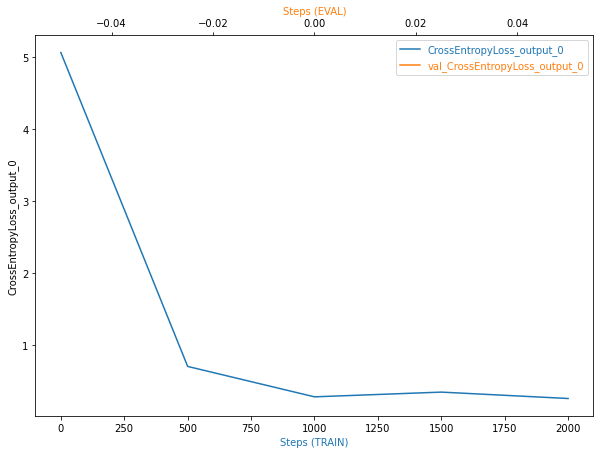

In [9]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import host_subplot

def get_data(trial, tname, mode):
    tensor = trial.tensor(tname)
    steps = tensor.steps(mode=mode)
    vals = []
    for s in steps:
        vals.append(tensor.value(s, mode=mode))
    return steps, vals

def plot_tensor(trial, tensor_name):

    steps_train, vals_train = get_data(trial, tensor_name, mode=ModeKeys.TRAIN)
    print("loaded TRAIN data")
    steps_eval, vals_eval = get_data(trial, tensor_name, mode=ModeKeys.EVAL)
    print("loaded EVAL data")

    fig = plt.figure(figsize=(10, 7))
    host = host_subplot(111)

    par = host.twiny()

    host.set_xlabel("Steps (TRAIN)")
    par.set_xlabel("Steps (EVAL)")
    host.set_ylabel(tensor_name)

    (p1,) = host.plot(steps_train, vals_train, label=tensor_name)
    print("completed TRAIN plot")
    (p2,) = par.plot(steps_eval, vals_eval, label="val_" + tensor_name)
    print("completed EVAL plot")
    leg = plt.legend()

    host.xaxis.get_label().set_color(p1.get_color())
    leg.texts[0].set_color(p1.get_color())

    par.xaxis.get_label().set_color(p2.get_color())
    leg.texts[1].set_color(p2.get_color())

    plt.ylabel(tensor_name)

    plt.show()
    
plot_tensor(trial, "CrossEntropyLoss_output_0")

**TODO**: Is there some anomalous behaviour in your debugging output? If so, what is the error and how will you fix it?  
**TODO**: If not, suppose there was an error. What would that error look like and how would you have fixed it?

In [10]:
# Profiler output
from smdebug.profiler.analysis.notebook_utils.timeline_charts import TimelineCharts

system_metrics_reader = tj.get_systems_metrics_reader()
system_metrics_reader.refresh_event_file_list()

view_timeline_charts = TimelineCharts(
    system_metrics_reader,
    framework_metrics_reader=None,
    select_dimensions=["CPU", "GPU"],
    select_events=["total"],
)
rule_output_path = 's3://sagemaker-us-east-1-824391236840/pytorch-training-2022-09-12-08-46-49-139/rule-output'
#rule_output_path = estimator.output_path + estimator.latest_training_job.job_name + "/rule-output"
print(f"You will find the profiler report in {rule_output_path}")

! aws s3 ls {rule_output_path} --recursive
! aws s3 cp {rule_output_path} ./ --recursive

[2022-09-28 09:17:17.926 sagemaker-data-scienc-ml-t3-medium-5812005f1de07e20cb211bb2dcf1:16 INFO metrics_reader_base.py:134] Getting 67 event files
select events:['total']
select dimensions:['CPU', 'GPU']
filtered_events:{'total'}
filtered_dimensions:{'CPUUtilization-nodeid:algo-1'}


You will find the profiler report in s3://sagemaker-us-east-1-824391236840/pytorch-training-2022-09-12-08-46-49-139/rule-output
2022-09-12 09:54:35     387090 pytorch-training-2022-09-12-08-46-49-139/rule-output/ProfilerReport/profiler-output/profiler-report.html
2022-09-12 09:54:34     237132 pytorch-training-2022-09-12-08-46-49-139/rule-output/ProfilerReport/profiler-output/profiler-report.ipynb
2022-09-12 09:54:30        192 pytorch-training-2022-09-12-08-46-49-139/rule-output/ProfilerReport/profiler-output/profiler-reports/BatchSize.json
2022-09-12 09:54:30        200 pytorch-training-2022-09-12-08-46-49-139/rule-output/ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json
2022-09-12 09:54:30       2116 pytorch-training-2022-09-12-08-46-49-139/rule-output/ProfilerReport/profiler-output/profiler-reports/Dataloader.json
2022-09-12 09:54:30        127 pytorch-training-2022-09-12-08-46-49-139/rule-output/ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.jso

In [ ]:
import os

# Get the autogenerated folder name of profiler report
profiler_report_name = [
    rule["RuleConfigurationName"]
    for rule in estimator.latest_training_job.rule_job_summary()
    if "Profiler" in rule["RuleConfigurationName"]
][0]

import IPython

IPython.display.HTML(filename=profiler_report_name + "/profiler-output/profiler-report.html"

## Model Deploying

In [9]:
# Deploy the model to an endpoint

predictor=estimator.deploy(initial_instance_count=1, instance_type="ml.t2.medium")

ValueError: Estimator is not associated with a training job

In [9]:
training_job_name = 'pytorch-training-2022-09-12-08-46-49-139'
my_estimator = sagemaker.estimator.Estimator.attach(training_job_name)
predictor = my_estimator.deploy(initial_instance_count = 1, instance_type = 'ml.m5.xlarge')


2022-09-12 09:54:49 Starting - Preparing the instances for training
2022-09-12 09:54:49 Downloading - Downloading input data
2022-09-12 09:54:49 Training - Training image download completed. Training in progress.
2022-09-12 09:54:49 Uploading - Uploading generated training model
2022-09-12 09:54:49 Completed - Training job completed
-------------------------------------------*

UnexpectedStatusException: Error hosting endpoint pytorch-training-2022-10-01-13-17-35-935: Failed. Reason: The primary container for production variant AllTraffic did not pass the ping health check. Please check CloudWatch logs for this endpoint..

In [ ]:
# TODO: Run an prediction on the endpoint

import base64 # encode/decode image in base64
import json
import requests
import torch
import torchvision
import PIL
import torchvision.transforms as transforms
import numpy as np

transform = transforms.Compose([
        transforms.Resize(256),
        transforms.RandomCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

# Test images outside of dataset. The comment after is the result. All tested dogs are not breeds in the actual training data.
PIL_image = PIL.Image.open('image_tests/dog2.jpg') #24 Bichon frise
#PIL_image = PIL.Image.open('testImages/20200912_121320.jpg') #52, 24 Clumber Spaniel, Bichon Frise

#PIL_image = PIL.Image.open('testImages/Rolo.png') #120 Pharaoh Hound
#PIL_image = PIL.Image.open('testImages/DSC08918.JPG') #116 Parson Russell Terrier

#PIL_image = PIL.Image.open('testImages/DSC01822.JPG') #58 Dandie dinmont terrier
#PIL_image = PIL.Image.open('testImages/Lucy.png') #42 Cairn Terrier

#PIL_image = PIL.Image.open('testImages/IMG-20210419-WA0000.jpg') #97 Lakeland Terrier
#PIL_image = PIL.Image.open('testImages/IMG-20210727-WA0000.jpg') #72 German Shorthaired Pointer

#PIL_image = PIL.Image.open('dogImages/dogImages/test/024.Bichon_frise/Bichon_frise_01707.jpg') #24 
#PIL_image = PIL.Image.open('dogImages/dogImages/test/001.Affenpinscher/Affenpinscher_00003.jpg') #1

image = transform(PIL_image)

payload = image.unsqueeze(dim=0)

response = predictor.predict(payload)

np.argmax(response) + 1

In [ ]:
# shutdown/delete endpoint once the work is done
predictor.delete_endpoint()